In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Fri Dec  6 09:05:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [14]:

def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

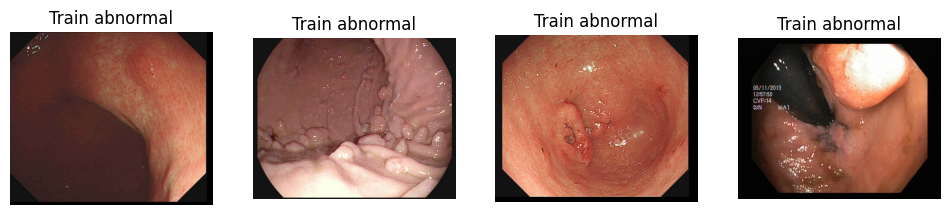

Train abnormal 총 이미지 수: 106


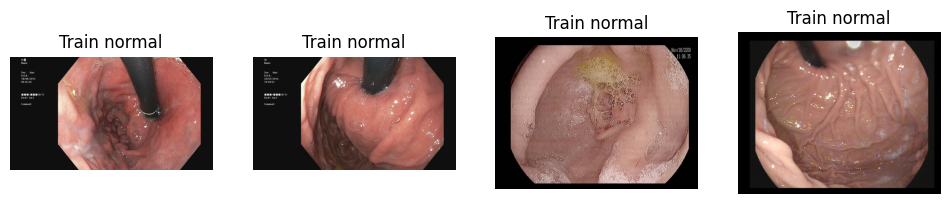

Train normal 총 이미지 수: 191


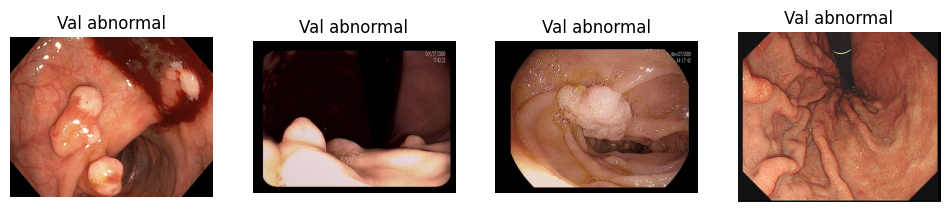

Val abnormal 총 이미지 수: 20


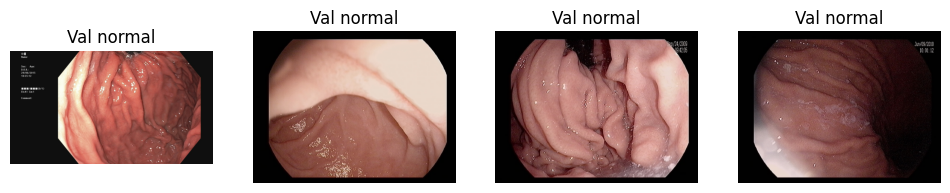

Val normal 총 이미지 수: 21


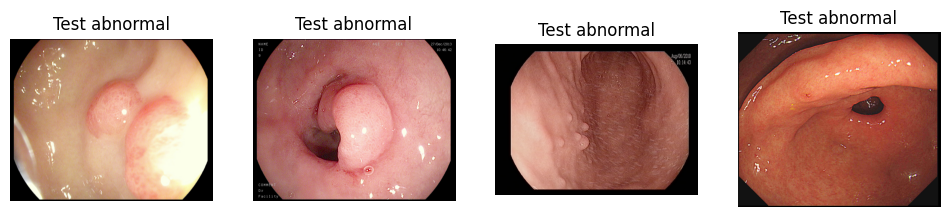

Test abnormal 총 이미지 수: 12


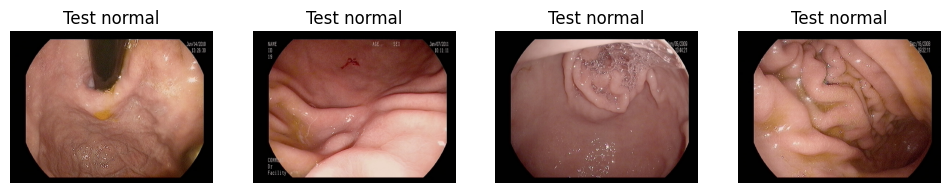

Test normal 총 이미지 수: 19


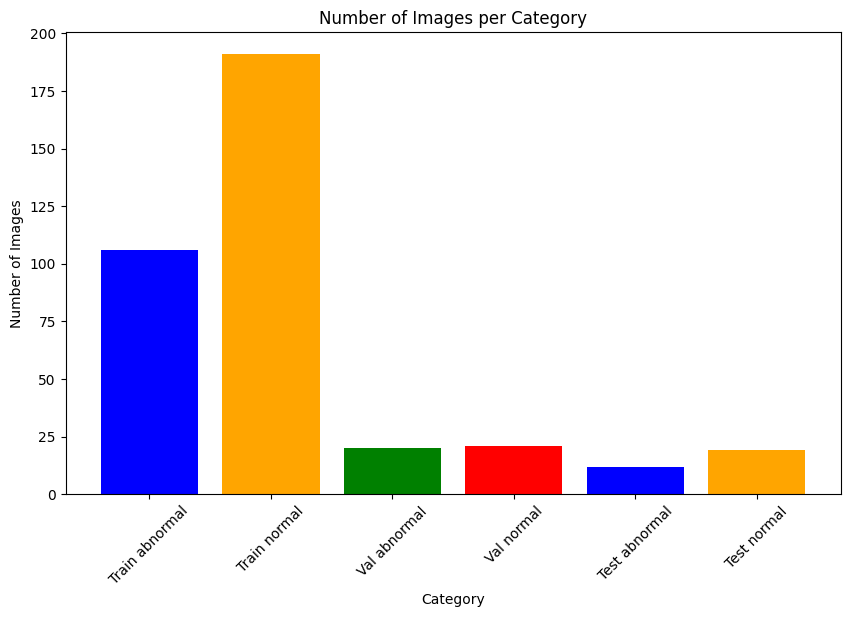

In [15]:
# 이미지와 바 그래프 출력
categories = ['Train abnormal', 'Train normal', 'Val abnormal', 'Val normal', 'Test abnormal', 'Test normal']


for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [22]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.2),
            iaa.Sometimes(0.3, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
            iaa.Sometimes(0.3, iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25)),

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [23]:
# from albumentations import (
#     HorizontalFlip, VerticalFlip, Rotate, ElasticTransform, Compose, OneOf
# )
# import numpy as np

# # Albumentations를 사용한 커스텀 데이터셋 정의
# class ImgAugTransform:
#     def __init__(self):
#         self.aug = Compose([
#             HorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
#             VerticalFlip(p=0.2),  # 20% 확률로 상하 반전
#             OneOf([  # 30% 확률로 아래 중 하나를 적용
#                 Rotate(limit=20, border_mode=0, p=1.0),  # -20도에서 20도 사이 회전 (mode='symmetric' 대신 border_mode=0 사용)
#                 ElasticTransform(alpha=1, sigma=0.25, alpha_affine=0, p=1.0),  # 탄성 변형
#             ], p=0.3),
#         ])

#     def __call__(self, img):
#         img = np.array(img)
#         augmented = self.aug(image=img)
#         return augmented['image']


In [24]:

class CustomDataset(ImageFolder):
    def __init__(self, root, abnormal_class_idx=0, oversample_factor=1, imgaug=None, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug
        self.abnormal_class_idx = abnormal_class_idx
        self.oversample_factor = oversample_factor

        self.samples = self._oversample_abnormal_class()

    def _oversample_abnormal_class(self):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        abnormal_samples = class_samples.get(self.abnormal_class_idx, [])
        oversampled_abnormal_samples = abnormal_samples * self.oversample_factor

        all_samples = []
        for target, paths in class_samples.items():
            if target == self.abnormal_class_idx:
                all_samples.extend([(path, target) for path in oversampled_abnormal_samples])
            else:
                all_samples.extend([(path, target) for path in paths])

        return all_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [25]:

from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:

train_path = '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/train'
val_path = '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/val'

train_dataset = CustomDataset(train_path, abnormal_class_idx=0, oversample_factor=2, imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset(val_path, abnormal_class_idx=0, oversample_factor=1, imgaug=None, transform=pytorch_transforms)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [28]:
def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):

    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    rows = 2
    cols = 4
    for i, label in enumerate(labels[:8]):
        class_name = idx_to_class[label.item()]
        x = (i % cols) * (img.shape[1] // cols) + (img.shape[1] // cols) // 2
        y = (i // cols) * (img.shape[0] // rows) + (img.shape[0] // rows) // 2
        plt.text(x, y, f'{label.item()}, {class_name}', color='white', fontsize=14,
                 horizontalalignment='center', verticalalignment='center')

    plt.show()

In [29]:

dataiter = iter(train_loader)
images, label = next(dataiter)

class_to_idx = train_loader.dataset.class_to_idx

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

Output hidden; open in https://colab.research.google.com to view.

In [30]:

efficientnet = models.efficientnet_b5(pretrained=True)

for param in efficientnet.parameters():
    param.requires_grad = False

efficientnet.classifier[1] = nn.Linear(2048, 1)
# efficientnet.classifier[1].requires_grad = True
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 133MB/s]


In [31]:
criterion = nn.BCEWithLogitsLoss()

In [32]:
def validate_model(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [33]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [34]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('RAdam', efficientnet, train_loader, val_loader, criterion, num_epochs=50)

Epoch 1/50: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


[RAdam] Epoch 1, Train Loss: 0.696892, Val Loss: 0.686755, Validation Accuracy: 65.85%


Epoch 2/50: 100%|██████████| 51/51 [00:25<00:00,  2.04it/s]


[RAdam] Epoch 2, Train Loss: 0.695879, Val Loss: 0.686065, Validation Accuracy: 56.10%


Epoch 3/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 3, Train Loss: 0.695542, Val Loss: 0.685898, Validation Accuracy: 51.22%


Epoch 4/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 4, Train Loss: 0.694510, Val Loss: 0.683937, Validation Accuracy: 43.90%


Epoch 5/50: 100%|██████████| 51/51 [00:25<00:00,  2.04it/s]


[RAdam] Epoch 5, Train Loss: 0.692800, Val Loss: 0.679718, Validation Accuracy: 51.22%


Epoch 6/50: 100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


[RAdam] Epoch 6, Train Loss: 0.696859, Val Loss: 0.679639, Validation Accuracy: 48.78%


Epoch 7/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 7, Train Loss: 0.695886, Val Loss: 0.678018, Validation Accuracy: 53.66%


Epoch 8/50: 100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


[RAdam] Epoch 8, Train Loss: 0.693145, Val Loss: 0.676806, Validation Accuracy: 56.10%


Epoch 9/50: 100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


[RAdam] Epoch 9, Train Loss: 0.689463, Val Loss: 0.676366, Validation Accuracy: 56.10%


Epoch 10/50: 100%|██████████| 51/51 [00:25<00:00,  2.01it/s]


[RAdam] Epoch 10, Train Loss: 0.692100, Val Loss: 0.675851, Validation Accuracy: 56.10%


Epoch 11/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 11, Train Loss: 0.691945, Val Loss: 0.674511, Validation Accuracy: 58.54%


Epoch 12/50: 100%|██████████| 51/51 [00:24<00:00,  2.07it/s]


[RAdam] Epoch 12, Train Loss: 0.696029, Val Loss: 0.673833, Validation Accuracy: 58.54%


Epoch 13/50: 100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


[RAdam] Epoch 13, Train Loss: 0.689574, Val Loss: 0.673759, Validation Accuracy: 56.10%


Epoch 14/50: 100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


[RAdam] Epoch 14, Train Loss: 0.682204, Val Loss: 0.672660, Validation Accuracy: 58.54%


Epoch 15/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 15, Train Loss: 0.687517, Val Loss: 0.672001, Validation Accuracy: 58.54%


Epoch 16/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 16, Train Loss: 0.680588, Val Loss: 0.671346, Validation Accuracy: 60.98%


Epoch 17/50: 100%|██████████| 51/51 [00:24<00:00,  2.08it/s]


[RAdam] Epoch 17, Train Loss: 0.685257, Val Loss: 0.669909, Validation Accuracy: 63.41%


Epoch 18/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 18, Train Loss: 0.681255, Val Loss: 0.669602, Validation Accuracy: 63.41%


Epoch 19/50: 100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


[RAdam] Epoch 19, Train Loss: 0.682369, Val Loss: 0.668694, Validation Accuracy: 60.98%


Epoch 20/50: 100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


[RAdam] Epoch 20, Train Loss: 0.681667, Val Loss: 0.667498, Validation Accuracy: 65.85%


Epoch 21/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 21, Train Loss: 0.685120, Val Loss: 0.666382, Validation Accuracy: 63.41%


Epoch 22/50: 100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


[RAdam] Epoch 22, Train Loss: 0.679775, Val Loss: 0.665426, Validation Accuracy: 63.41%


Epoch 23/50: 100%|██████████| 51/51 [00:25<00:00,  2.04it/s]


[RAdam] Epoch 23, Train Loss: 0.680043, Val Loss: 0.664467, Validation Accuracy: 65.85%


Epoch 24/50: 100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


[RAdam] Epoch 24, Train Loss: 0.677325, Val Loss: 0.663649, Validation Accuracy: 65.85%


Epoch 25/50: 100%|██████████| 51/51 [00:24<00:00,  2.08it/s]


[RAdam] Epoch 25, Train Loss: 0.671080, Val Loss: 0.662463, Validation Accuracy: 68.29%


Epoch 26/50: 100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


[RAdam] Epoch 26, Train Loss: 0.667804, Val Loss: 0.661149, Validation Accuracy: 70.73%


Epoch 27/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 27, Train Loss: 0.670334, Val Loss: 0.660613, Validation Accuracy: 73.17%


Epoch 28/50: 100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


[RAdam] Epoch 28, Train Loss: 0.669692, Val Loss: 0.659248, Validation Accuracy: 73.17%


Epoch 29/50: 100%|██████████| 51/51 [00:24<00:00,  2.04it/s]


[RAdam] Epoch 29, Train Loss: 0.668880, Val Loss: 0.658024, Validation Accuracy: 73.17%


Epoch 30/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 30, Train Loss: 0.667795, Val Loss: 0.656690, Validation Accuracy: 73.17%


Epoch 31/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 31, Train Loss: 0.671531, Val Loss: 0.655358, Validation Accuracy: 75.61%


Epoch 32/50: 100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


[RAdam] Epoch 32, Train Loss: 0.670419, Val Loss: 0.653833, Validation Accuracy: 75.61%


Epoch 33/50: 100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


[RAdam] Epoch 33, Train Loss: 0.671582, Val Loss: 0.652582, Validation Accuracy: 75.61%


Epoch 34/50: 100%|██████████| 51/51 [00:24<00:00,  2.04it/s]


[RAdam] Epoch 34, Train Loss: 0.666204, Val Loss: 0.651174, Validation Accuracy: 75.61%


Epoch 35/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 35, Train Loss: 0.661307, Val Loss: 0.650545, Validation Accuracy: 75.61%


Epoch 36/50: 100%|██████████| 51/51 [00:25<00:00,  2.01it/s]


[RAdam] Epoch 36, Train Loss: 0.661859, Val Loss: 0.649972, Validation Accuracy: 78.05%


Epoch 37/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 37, Train Loss: 0.655706, Val Loss: 0.649570, Validation Accuracy: 78.05%


Epoch 38/50: 100%|██████████| 51/51 [00:25<00:00,  2.01it/s]


[RAdam] Epoch 38, Train Loss: 0.655920, Val Loss: 0.648064, Validation Accuracy: 78.05%


Epoch 39/50: 100%|██████████| 51/51 [00:25<00:00,  2.03it/s]


[RAdam] Epoch 39, Train Loss: 0.660374, Val Loss: 0.646187, Validation Accuracy: 78.05%


Epoch 40/50: 100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


[RAdam] Epoch 40, Train Loss: 0.656905, Val Loss: 0.645058, Validation Accuracy: 78.05%


Epoch 41/50: 100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


[RAdam] Epoch 41, Train Loss: 0.658112, Val Loss: 0.644497, Validation Accuracy: 80.49%


Epoch 42/50: 100%|██████████| 51/51 [00:25<00:00,  2.04it/s]


[RAdam] Epoch 42, Train Loss: 0.653905, Val Loss: 0.642752, Validation Accuracy: 80.49%


Epoch 43/50: 100%|██████████| 51/51 [00:25<00:00,  2.04it/s]


[RAdam] Epoch 43, Train Loss: 0.653140, Val Loss: 0.641577, Validation Accuracy: 80.49%


Epoch 44/50: 100%|██████████| 51/51 [00:25<00:00,  2.01it/s]


[RAdam] Epoch 44, Train Loss: 0.650289, Val Loss: 0.639960, Validation Accuracy: 80.49%


Epoch 45/50: 100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


[RAdam] Epoch 45, Train Loss: 0.652679, Val Loss: 0.638846, Validation Accuracy: 80.49%


Epoch 46/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 46, Train Loss: 0.650038, Val Loss: 0.638090, Validation Accuracy: 80.49%


Epoch 47/50: 100%|██████████| 51/51 [00:25<00:00,  2.02it/s]


[RAdam] Epoch 47, Train Loss: 0.647950, Val Loss: 0.637486, Validation Accuracy: 82.93%


Epoch 48/50: 100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


[RAdam] Epoch 48, Train Loss: 0.652418, Val Loss: 0.636512, Validation Accuracy: 82.93%


Epoch 49/50: 100%|██████████| 51/51 [00:24<00:00,  2.04it/s]


[RAdam] Epoch 49, Train Loss: 0.641211, Val Loss: 0.635592, Validation Accuracy: 85.37%


Epoch 50/50: 100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


[RAdam] Epoch 50, Train Loss: 0.642922, Val Loss: 0.633361, Validation Accuracy: 85.37%


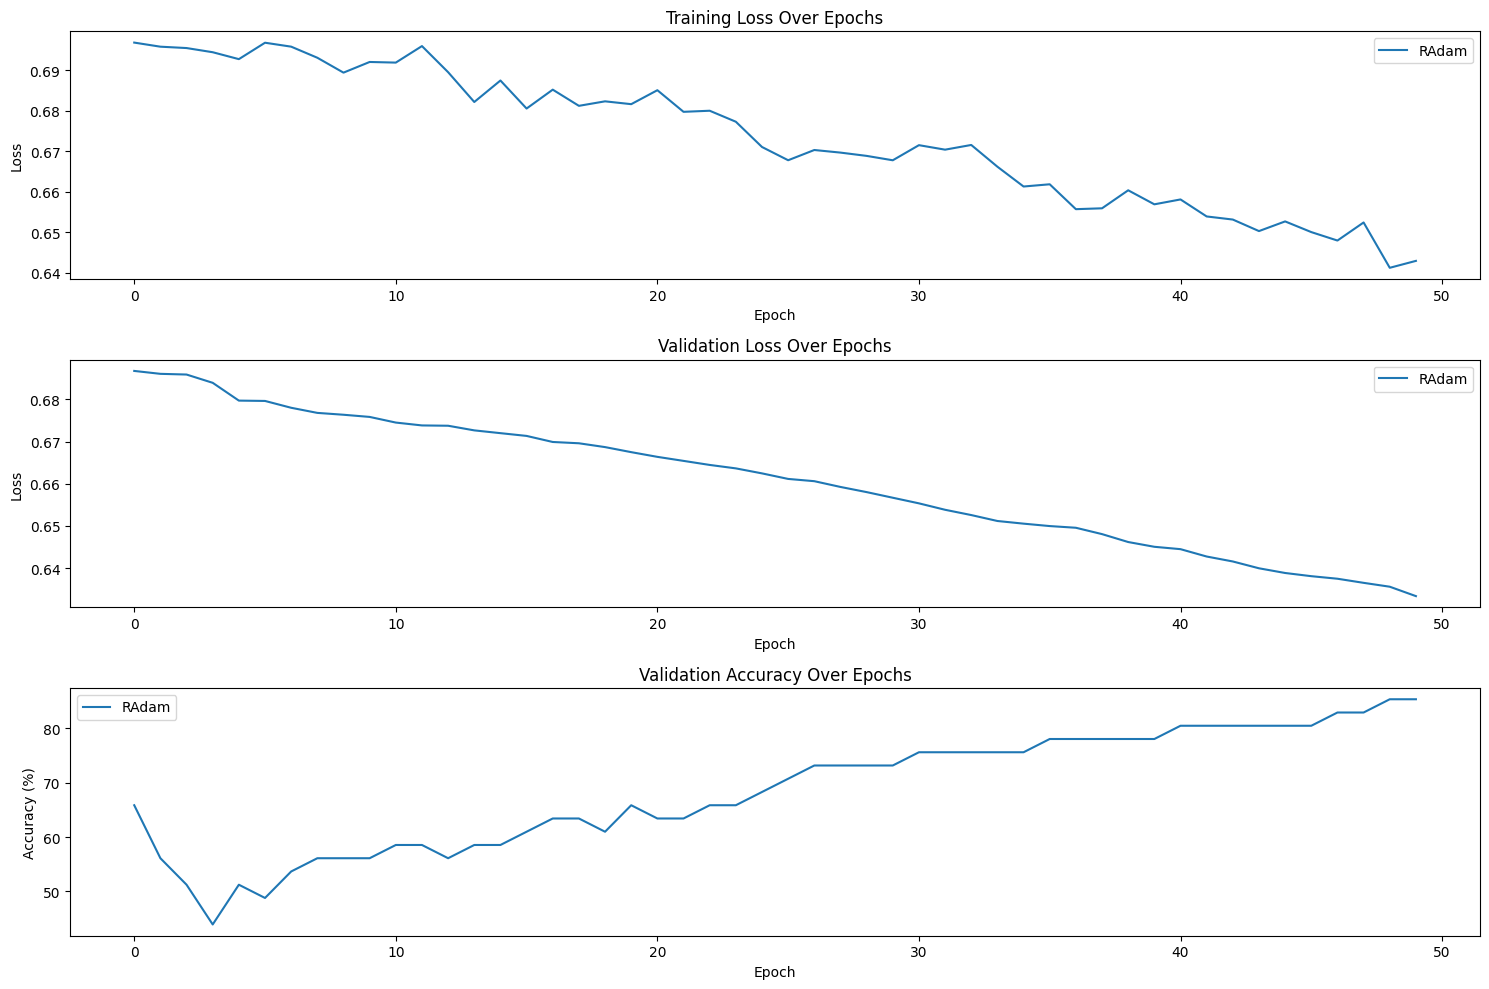

In [35]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_efficientnet, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_accuracies_efficientnet, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

In [37]:
class_folders = {
    'abnormal': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/test/abnormal',
    'normal': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/test/normal'
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        efficientnet.eval()
        with torch.no_grad():
            outputs = efficientnet(image)
            probs = torch.sigmoid(outputs).item()
            prediction = 'normal' if probs >= 0.5 else 'abnormal'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'normal' else 0)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

In [39]:
class_folders = {
    'abnormal': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/test/abnormal',
    'normal': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/5/test/normal'
}

efficientnet_metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms)


print("resnet Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*efficientnet_metrics))

resnet Metrics: Accuracy: 0.7419, Precision: 0.7619, Recall: 0.8421, F1: 0.8000


# 456입력으로 하는 모델 적용

In [ ]:
# ConvNeXt 모델 로드 (ConvNeXt Base를 사용)
convnext = models.convnext_base(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in convnext.parameters():
    param.requires_grad = False

# Classifier 부분을 수정하여 Binary Classification에 맞게 변경
# ConvNeXt의 classifier 구조는 [LayerNorm, Linear]로 구성되어 있음
num_features = convnext.classifier[2].in_features  # Linear 레이어의 입력 차원 추출
convnext.classifier[2] = nn.Linear(num_features, 1)  # 이진 분류를 위한 출력 1개 설정

# 수정한 classifier의 파라미터는 학습 가능하도록 설정
for param in convnext.classifier.parameters():
    param.requires_grad = True

# 모델을 장치로 이동
convnext = convnext.to(device)


In [ ]:
vit = models.vit_b_16(pretrained=True)
num_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_features, 1)
for param in vit.heads.parameters():
    param.requires_grad = True
vit = vit.to(device)


In [65]:
swin = models.swin_t(pretrained=True)
num_features = swin.head.in_features
swin.head = nn.Linear(num_features, 1)
for param in swin.head.parameters():
    param.requires_grad = True
swin = swin.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses_convnext, val_losses_convnext, val_accuracies_v = train_model('Lion', convnext, train_loader, val_loader, criterion, num_epochs=50)

In [ ]:
train_losses_vit, val_losses_vit, val_accuracies_vit = train_model('Lion', vit, train_loader, val_loader, criterion, num_epochs=50)

In [66]:
train_losses_swin, val_losses_swin, val_accuracies_swin = train_model('Lion', swin, train_loader, val_loader, criterion, num_epochs=50)

Epoch 1/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 1, Train Loss: 0.546490, Val Loss: 0.427518, Validation Accuracy: 78.05%


Epoch 2/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 2, Train Loss: 0.399443, Val Loss: 0.354373, Validation Accuracy: 82.93%


Epoch 3/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 3, Train Loss: 0.288463, Val Loss: 0.351529, Validation Accuracy: 85.37%


Epoch 4/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 4, Train Loss: 0.195468, Val Loss: 0.332732, Validation Accuracy: 87.80%


Epoch 5/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 5, Train Loss: 0.133780, Val Loss: 0.259875, Validation Accuracy: 90.24%


Epoch 6/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 6, Train Loss: 0.077827, Val Loss: 0.291221, Validation Accuracy: 90.24%


Epoch 7/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 7, Train Loss: 0.103372, Val Loss: 0.147461, Validation Accuracy: 95.12%


Epoch 8/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 8, Train Loss: 0.084522, Val Loss: 0.619489, Validation Accuracy: 85.37%


Epoch 9/50: 100%|██████████| 51/51 [00:40<00:00,  1.24it/s]


[Lion] Epoch 9, Train Loss: 0.099872, Val Loss: 0.276634, Validation Accuracy: 85.37%


Epoch 10/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 10, Train Loss: 0.042267, Val Loss: 0.471976, Validation Accuracy: 85.37%


Epoch 11/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 11, Train Loss: 0.040733, Val Loss: 0.657108, Validation Accuracy: 82.93%


Epoch 12/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 12, Train Loss: 0.070613, Val Loss: 0.499472, Validation Accuracy: 85.37%


Epoch 13/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 13, Train Loss: 0.087299, Val Loss: 0.221194, Validation Accuracy: 92.68%


Epoch 14/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 14, Train Loss: 0.051225, Val Loss: 0.282572, Validation Accuracy: 87.80%


Epoch 15/50: 100%|██████████| 51/51 [00:40<00:00,  1.26it/s]


[Lion] Epoch 15, Train Loss: 0.068500, Val Loss: 0.325515, Validation Accuracy: 87.80%


Epoch 16/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 16, Train Loss: 0.031397, Val Loss: 0.257443, Validation Accuracy: 90.24%


Epoch 17/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 17, Train Loss: 0.018650, Val Loss: 0.384428, Validation Accuracy: 90.24%


Epoch 18/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 18, Train Loss: 0.062611, Val Loss: 0.380303, Validation Accuracy: 90.24%


Epoch 19/50: 100%|██████████| 51/51 [00:40<00:00,  1.24it/s]


[Lion] Epoch 19, Train Loss: 0.076101, Val Loss: 0.538218, Validation Accuracy: 85.37%


Epoch 20/50: 100%|██████████| 51/51 [00:40<00:00,  1.24it/s]


[Lion] Epoch 20, Train Loss: 0.051794, Val Loss: 0.234450, Validation Accuracy: 92.68%


Epoch 21/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 21, Train Loss: 0.016387, Val Loss: 0.312449, Validation Accuracy: 95.12%


Epoch 22/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 22, Train Loss: 0.047943, Val Loss: 0.263754, Validation Accuracy: 92.68%


Epoch 23/50: 100%|██████████| 51/51 [00:40<00:00,  1.24it/s]


[Lion] Epoch 23, Train Loss: 0.042529, Val Loss: 0.331782, Validation Accuracy: 87.80%


Epoch 24/50: 100%|██████████| 51/51 [00:40<00:00,  1.24it/s]


[Lion] Epoch 24, Train Loss: 0.032418, Val Loss: 0.271135, Validation Accuracy: 87.80%


Epoch 25/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 25, Train Loss: 0.043870, Val Loss: 0.493703, Validation Accuracy: 80.49%


Epoch 26/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 26, Train Loss: 0.017921, Val Loss: 0.667123, Validation Accuracy: 82.93%


Epoch 27/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 27, Train Loss: 0.046508, Val Loss: 0.479819, Validation Accuracy: 90.24%


Epoch 28/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 28, Train Loss: 0.013092, Val Loss: 0.707286, Validation Accuracy: 87.80%


Epoch 29/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 29, Train Loss: 0.046470, Val Loss: 0.462855, Validation Accuracy: 87.80%


Epoch 30/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 30, Train Loss: 0.070009, Val Loss: 0.217737, Validation Accuracy: 90.24%


Epoch 31/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 31, Train Loss: 0.042846, Val Loss: 0.392854, Validation Accuracy: 85.37%


Epoch 32/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 32, Train Loss: 0.058623, Val Loss: 0.269505, Validation Accuracy: 87.80%


Epoch 33/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 33, Train Loss: 0.030817, Val Loss: 0.396291, Validation Accuracy: 87.80%


Epoch 34/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 34, Train Loss: 0.027126, Val Loss: 0.312132, Validation Accuracy: 92.68%


Epoch 35/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 35, Train Loss: 0.033588, Val Loss: 0.946653, Validation Accuracy: 87.80%


Epoch 36/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 36, Train Loss: 0.058581, Val Loss: 0.340654, Validation Accuracy: 87.80%


Epoch 37/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 37, Train Loss: 0.068176, Val Loss: 0.394478, Validation Accuracy: 87.80%


Epoch 38/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 38, Train Loss: 0.062786, Val Loss: 0.259672, Validation Accuracy: 85.37%


Epoch 39/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 39, Train Loss: 0.068956, Val Loss: 0.276343, Validation Accuracy: 92.68%


Epoch 40/50: 100%|██████████| 51/51 [00:42<00:00,  1.21it/s]


[Lion] Epoch 40, Train Loss: 0.045351, Val Loss: 0.479355, Validation Accuracy: 87.80%


Epoch 41/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 41, Train Loss: 0.031266, Val Loss: 0.368272, Validation Accuracy: 87.80%


Epoch 42/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 42, Train Loss: 0.026838, Val Loss: 0.535103, Validation Accuracy: 87.80%


Epoch 43/50: 100%|██████████| 51/51 [00:41<00:00,  1.21it/s]


[Lion] Epoch 43, Train Loss: 0.048084, Val Loss: 0.614022, Validation Accuracy: 87.80%


Epoch 44/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 44, Train Loss: 0.032523, Val Loss: 0.676658, Validation Accuracy: 85.37%


Epoch 45/50: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


[Lion] Epoch 45, Train Loss: 0.027202, Val Loss: 0.436340, Validation Accuracy: 85.37%


Epoch 46/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 46, Train Loss: 0.061894, Val Loss: 0.531357, Validation Accuracy: 85.37%


Epoch 47/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 47, Train Loss: 0.041755, Val Loss: 0.365093, Validation Accuracy: 87.80%


Epoch 48/50: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


[Lion] Epoch 48, Train Loss: 0.034411, Val Loss: 0.325392, Validation Accuracy: 85.37%


Epoch 49/50: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


[Lion] Epoch 49, Train Loss: 0.031353, Val Loss: 0.788773, Validation Accuracy: 85.37%


Epoch 50/50: 100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


[Lion] Epoch 50, Train Loss: 0.080258, Val Loss: 0.519504, Validation Accuracy: 85.37%


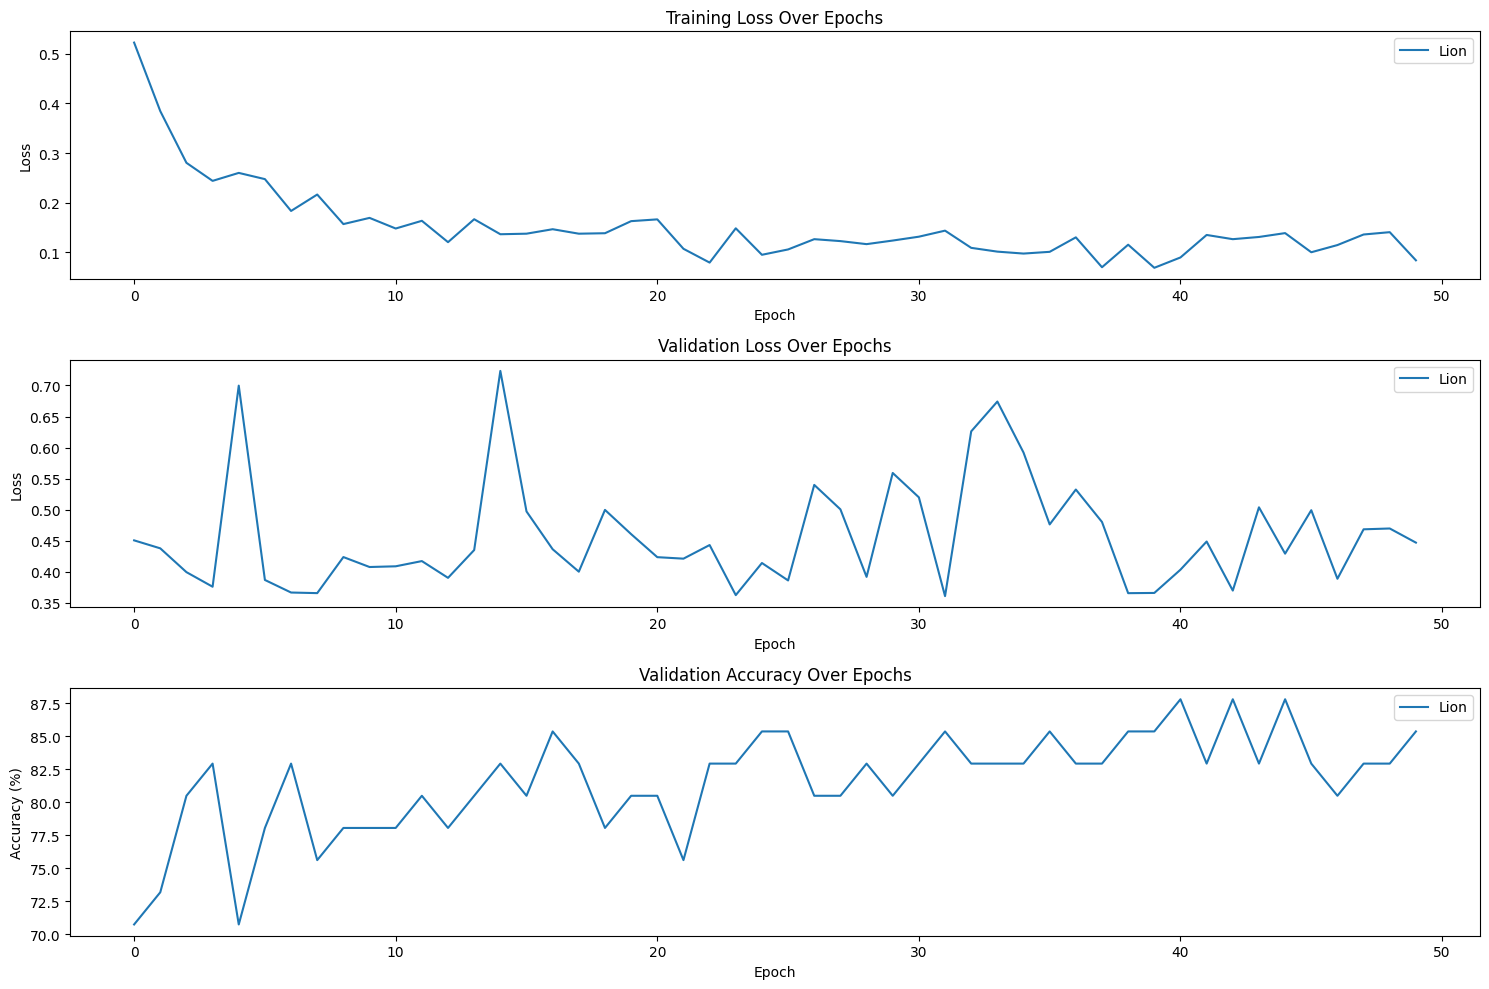

In [69]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_efficientnet, label='Lion')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='Lion')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_accuracies_efficientnet, label='Lion')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [70]:
swin_metrics = evaluate_model(swin, class_folders, pytorch_transforms)


print("resnet Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*swin_metrics))

resnet Metrics: Accuracy: 0.9032, Precision: 0.8636, Recall: 1.0000, F1: 0.9268


# 이미지 resize(224) 후 ConvNeXt, ViT, SwinTransformer 적용 + Optimizer 변경

In [50]:
pytorch_transforms_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [51]:

train_dataset_224 = CustomDataset(train_path, abnormal_class_idx=0, oversample_factor=2, imgaug=ImgAugTransform(), transform=pytorch_transforms_224)
val_dataset_224 = CustomDataset(val_path, abnormal_class_idx=0, oversample_factor=1, imgaug=None, transform=pytorch_transforms_224)

In [53]:
train_loader_224 = DataLoader(train_dataset_224, batch_size=8, shuffle=True)
val_loader_224 = DataLoader(val_dataset_224, batch_size=8, shuffle=False)

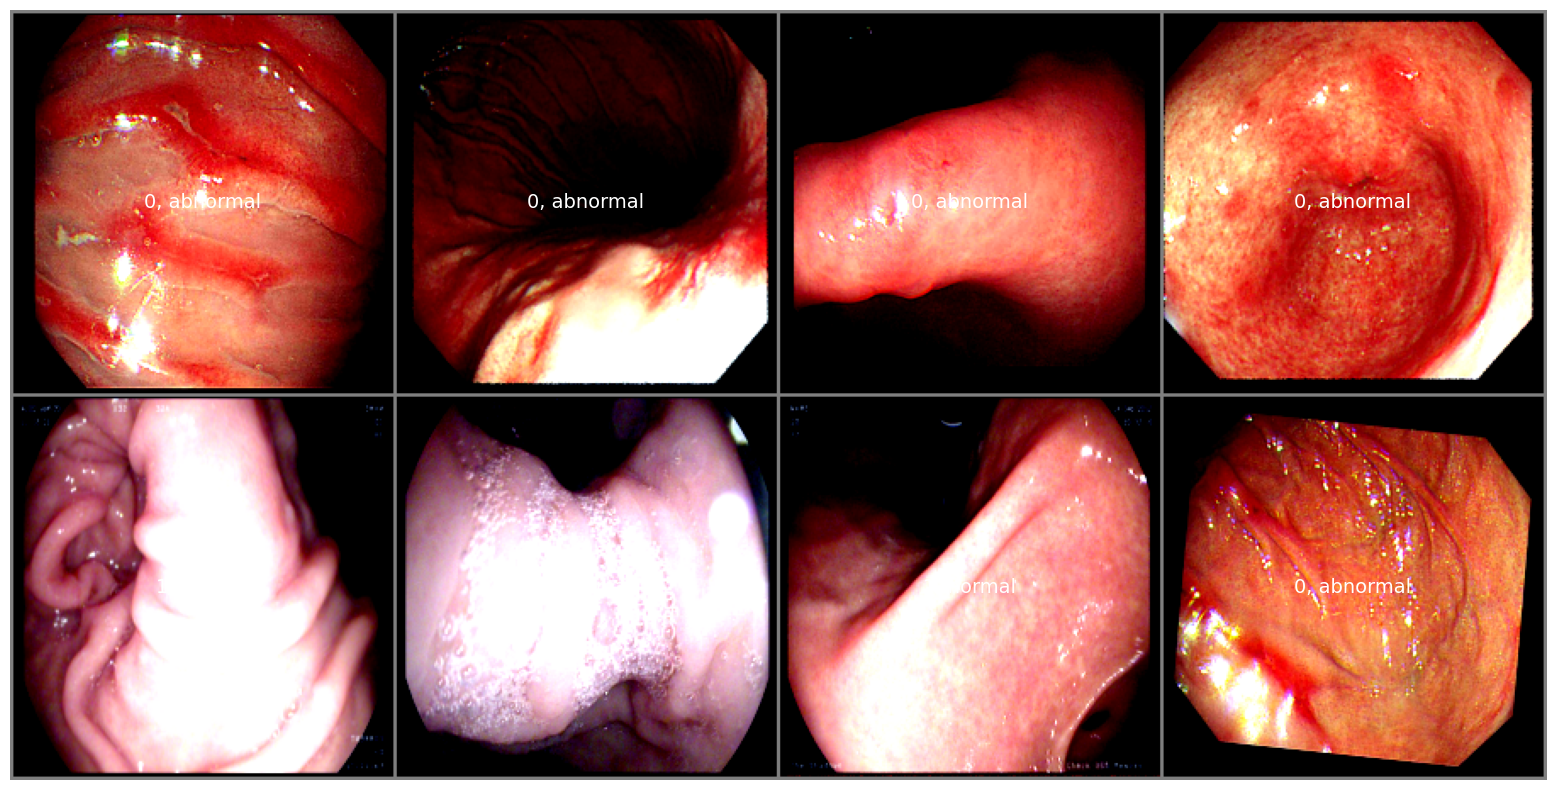

In [55]:

dataiter = iter(train_loader_224)
images, label = next(dataiter)

class_to_idx_224 = train_loader_224.dataset.class_to_idx

imshow(make_grid(images[:8], nrow=4), label, class_to_idx_224, size=(20, 10))

### ConvNeXt 모델

In [56]:
convnext = models.convnext_base(pretrained=True)

for param in convnext.parameters():
    param.requires_grad = False

num_features = convnext.classifier[2].in_features
convnext.classifier[2] = nn.Linear(num_features, 1)

for param in convnext.classifier.parameters():
    param.requires_grad = True

convnext = convnext.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Optimizer Lion (EvoNorm 기반의 경량 Optimizer)

In [57]:
# !pip install lion-pytorch

# from lion_pytorch import Lion

# optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-2)

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00001, betas=(0.9, 0.999))
    elif optimizer_name == 'Lion':
        optimizer = Lion(net.parameters(), lr=0.00001, weight_decay=1e-2)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        # tqdm을 사용하여 진행 상황 표시
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 에폭 종료 후 로그 출력
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [58]:
train_losses_convnext, val_losses_convnext, val_accuracies_v = train_model('Lion', convnext, train_loader_224, val_loader_224, criterion, num_epochs=50)

Epoch 1/50: 100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


[Lion] Epoch 1, Train Loss: 0.734800, Val Loss: 0.772925, Validation Accuracy: 34.15%


Epoch 2/50: 100%|██████████| 51/51 [00:19<00:00,  2.68it/s]


[Lion] Epoch 2, Train Loss: 0.730124, Val Loss: 0.763086, Validation Accuracy: 39.02%


Epoch 3/50: 100%|██████████| 51/51 [00:18<00:00,  2.72it/s]


[Lion] Epoch 3, Train Loss: 0.708326, Val Loss: 0.752072, Validation Accuracy: 41.46%


Epoch 4/50: 100%|██████████| 51/51 [00:19<00:00,  2.68it/s]


[Lion] Epoch 4, Train Loss: 0.695163, Val Loss: 0.743411, Validation Accuracy: 43.90%


Epoch 5/50: 100%|██████████| 51/51 [00:18<00:00,  2.72it/s]


[Lion] Epoch 5, Train Loss: 0.688845, Val Loss: 0.736607, Validation Accuracy: 51.22%


Epoch 6/50: 100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


[Lion] Epoch 6, Train Loss: 0.684960, Val Loss: 0.728643, Validation Accuracy: 48.78%


Epoch 7/50: 100%|██████████| 51/51 [00:19<00:00,  2.63it/s]


[Lion] Epoch 7, Train Loss: 0.670839, Val Loss: 0.718391, Validation Accuracy: 51.22%


Epoch 8/50: 100%|██████████| 51/51 [00:19<00:00,  2.63it/s]


[Lion] Epoch 8, Train Loss: 0.660848, Val Loss: 0.709288, Validation Accuracy: 56.10%


Epoch 9/50: 100%|██████████| 51/51 [00:19<00:00,  2.68it/s]


[Lion] Epoch 9, Train Loss: 0.650694, Val Loss: 0.700985, Validation Accuracy: 58.54%


Epoch 10/50: 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


[Lion] Epoch 10, Train Loss: 0.642110, Val Loss: 0.694671, Validation Accuracy: 58.54%


Epoch 11/50: 100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


[Lion] Epoch 11, Train Loss: 0.629710, Val Loss: 0.688574, Validation Accuracy: 58.54%


Epoch 12/50: 100%|██████████| 51/51 [00:19<00:00,  2.66it/s]


[Lion] Epoch 12, Train Loss: 0.625027, Val Loss: 0.681232, Validation Accuracy: 58.54%


Epoch 13/50: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


[Lion] Epoch 13, Train Loss: 0.611673, Val Loss: 0.673349, Validation Accuracy: 63.41%


Epoch 14/50: 100%|██████████| 51/51 [00:18<00:00,  2.69it/s]


[Lion] Epoch 14, Train Loss: 0.602716, Val Loss: 0.666549, Validation Accuracy: 65.85%


Epoch 15/50: 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


[Lion] Epoch 15, Train Loss: 0.594713, Val Loss: 0.660809, Validation Accuracy: 68.29%


Epoch 16/50: 100%|██████████| 51/51 [00:18<00:00,  2.69it/s]


[Lion] Epoch 16, Train Loss: 0.596982, Val Loss: 0.654443, Validation Accuracy: 68.29%


Epoch 17/50: 100%|██████████| 51/51 [00:18<00:00,  2.68it/s]


[Lion] Epoch 17, Train Loss: 0.583757, Val Loss: 0.648723, Validation Accuracy: 68.29%


Epoch 18/50: 100%|██████████| 51/51 [00:19<00:00,  2.68it/s]


[Lion] Epoch 18, Train Loss: 0.570432, Val Loss: 0.642671, Validation Accuracy: 65.85%


Epoch 19/50: 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


[Lion] Epoch 19, Train Loss: 0.565862, Val Loss: 0.635186, Validation Accuracy: 65.85%


Epoch 20/50: 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


[Lion] Epoch 20, Train Loss: 0.556989, Val Loss: 0.629065, Validation Accuracy: 65.85%


Epoch 21/50: 100%|██████████| 51/51 [00:19<00:00,  2.68it/s]


[Lion] Epoch 21, Train Loss: 0.552276, Val Loss: 0.626059, Validation Accuracy: 65.85%


Epoch 22/50: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


[Lion] Epoch 22, Train Loss: 0.546735, Val Loss: 0.620213, Validation Accuracy: 65.85%


Epoch 23/50: 100%|██████████| 51/51 [00:18<00:00,  2.69it/s]


[Lion] Epoch 23, Train Loss: 0.539786, Val Loss: 0.614977, Validation Accuracy: 68.29%


Epoch 24/50: 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


[Lion] Epoch 24, Train Loss: 0.531189, Val Loss: 0.609011, Validation Accuracy: 68.29%


Epoch 25/50: 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


[Lion] Epoch 25, Train Loss: 0.529303, Val Loss: 0.604411, Validation Accuracy: 68.29%


Epoch 26/50: 100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


[Lion] Epoch 26, Train Loss: 0.520816, Val Loss: 0.599980, Validation Accuracy: 68.29%


Epoch 27/50: 100%|██████████| 51/51 [00:19<00:00,  2.63it/s]


[Lion] Epoch 27, Train Loss: 0.514723, Val Loss: 0.592512, Validation Accuracy: 68.29%


Epoch 28/50: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


[Lion] Epoch 28, Train Loss: 0.514291, Val Loss: 0.590491, Validation Accuracy: 65.85%


Epoch 29/50: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


[Lion] Epoch 29, Train Loss: 0.502336, Val Loss: 0.586450, Validation Accuracy: 70.73%


Epoch 30/50: 100%|██████████| 51/51 [00:18<00:00,  2.71it/s]


[Lion] Epoch 30, Train Loss: 0.503793, Val Loss: 0.582902, Validation Accuracy: 70.73%


Epoch 31/50: 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


[Lion] Epoch 31, Train Loss: 0.493264, Val Loss: 0.579079, Validation Accuracy: 70.73%


Epoch 32/50: 100%|██████████| 51/51 [00:18<00:00,  2.71it/s]


[Lion] Epoch 32, Train Loss: 0.494788, Val Loss: 0.574914, Validation Accuracy: 70.73%


Epoch 33/50: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


[Lion] Epoch 33, Train Loss: 0.487380, Val Loss: 0.567630, Validation Accuracy: 73.17%


Epoch 34/50: 100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


[Lion] Epoch 34, Train Loss: 0.484532, Val Loss: 0.562944, Validation Accuracy: 73.17%


Epoch 35/50: 100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


[Lion] Epoch 35, Train Loss: 0.469162, Val Loss: 0.560348, Validation Accuracy: 73.17%


Epoch 36/50: 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


[Lion] Epoch 36, Train Loss: 0.472608, Val Loss: 0.558998, Validation Accuracy: 73.17%


Epoch 37/50: 100%|██████████| 51/51 [00:19<00:00,  2.66it/s]


[Lion] Epoch 37, Train Loss: 0.475010, Val Loss: 0.555908, Validation Accuracy: 73.17%


Epoch 38/50: 100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


[Lion] Epoch 38, Train Loss: 0.467147, Val Loss: 0.551218, Validation Accuracy: 73.17%


Epoch 39/50: 100%|██████████| 51/51 [00:18<00:00,  2.73it/s]


[Lion] Epoch 39, Train Loss: 0.456133, Val Loss: 0.546893, Validation Accuracy: 73.17%


Epoch 40/50: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


[Lion] Epoch 40, Train Loss: 0.457470, Val Loss: 0.543541, Validation Accuracy: 73.17%


Epoch 41/50: 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


[Lion] Epoch 41, Train Loss: 0.459915, Val Loss: 0.541377, Validation Accuracy: 73.17%


Epoch 42/50: 100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


[Lion] Epoch 42, Train Loss: 0.459781, Val Loss: 0.540060, Validation Accuracy: 73.17%


Epoch 43/50: 100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


[Lion] Epoch 43, Train Loss: 0.447113, Val Loss: 0.536365, Validation Accuracy: 73.17%


Epoch 44/50: 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


[Lion] Epoch 44, Train Loss: 0.449357, Val Loss: 0.532816, Validation Accuracy: 73.17%


Epoch 45/50: 100%|██████████| 51/51 [00:18<00:00,  2.75it/s]


[Lion] Epoch 45, Train Loss: 0.440518, Val Loss: 0.528213, Validation Accuracy: 73.17%


Epoch 46/50: 100%|██████████| 51/51 [00:19<00:00,  2.68it/s]


[Lion] Epoch 46, Train Loss: 0.434549, Val Loss: 0.523413, Validation Accuracy: 75.61%


Epoch 47/50: 100%|██████████| 51/51 [00:18<00:00,  2.74it/s]


[Lion] Epoch 47, Train Loss: 0.437267, Val Loss: 0.518111, Validation Accuracy: 75.61%


Epoch 48/50: 100%|██████████| 51/51 [00:18<00:00,  2.69it/s]


[Lion] Epoch 48, Train Loss: 0.430825, Val Loss: 0.512826, Validation Accuracy: 78.05%


Epoch 49/50: 100%|██████████| 51/51 [00:18<00:00,  2.72it/s]


[Lion] Epoch 49, Train Loss: 0.426263, Val Loss: 0.509959, Validation Accuracy: 78.05%


Epoch 50/50: 100%|██████████| 51/51 [00:18<00:00,  2.73it/s]


[Lion] Epoch 50, Train Loss: 0.427211, Val Loss: 0.506446, Validation Accuracy: 80.49%


In [63]:
# Vision Transformer 모델 로드 (ViT Base 16x16 패치 사용)
vit = models.vit_b_16(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in vit.parameters():
    param.requires_grad = False

# Classifier 부분 수정 (ViT의 classifier는 heads.head에 위치)
num_features = vit.heads.head.in_features  # 기존 출력 레이어의 입력 크기
vit.heads.head = nn.Linear(num_features, 1)  # 이진 분류를 위한 출력 1개 설정

# 수정한 classifier의 파라미터는 학습 가능하도록 설정
for param in vit.heads.parameters():
    param.requires_grad = True

vit = vit.to(device)
# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정


# efficientnet.classifier[1] = nn.Linear(2048, 1)
# # efficientnet.classifier[1].requires_grad = True
# for param in efficientnet.classifier.parameters():
#     param.requires_grad = True

# efficientnet = efficientnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
train_losses_vit, val_losses_vit, val_accuracies_vit = train_model('Lion', vit, train_loader_224, val_loader_224, criterion, num_epochs=50)

Epoch 1/50: 100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


[Lion] Epoch 1, Train Loss: 0.753977, Val Loss: 0.767672, Validation Accuracy: 31.71%


Epoch 2/50: 100%|██████████| 51/51 [00:22<00:00,  2.25it/s]


[Lion] Epoch 2, Train Loss: 0.737322, Val Loss: 0.763742, Validation Accuracy: 34.15%


Epoch 3/50: 100%|██████████| 51/51 [00:22<00:00,  2.22it/s]


[Lion] Epoch 3, Train Loss: 0.732378, Val Loss: 0.757897, Validation Accuracy: 36.59%


Epoch 4/50: 100%|██████████| 51/51 [00:23<00:00,  2.21it/s]


[Lion] Epoch 4, Train Loss: 0.714506, Val Loss: 0.752254, Validation Accuracy: 41.46%


Epoch 5/50: 100%|██████████| 51/51 [00:22<00:00,  2.26it/s]


[Lion] Epoch 5, Train Loss: 0.698245, Val Loss: 0.746151, Validation Accuracy: 51.22%


Epoch 6/50: 100%|██████████| 51/51 [00:23<00:00,  2.20it/s]


[Lion] Epoch 6, Train Loss: 0.686812, Val Loss: 0.740550, Validation Accuracy: 56.10%


Epoch 7/50: 100%|██████████| 51/51 [00:22<00:00,  2.23it/s]


[Lion] Epoch 7, Train Loss: 0.666275, Val Loss: 0.732651, Validation Accuracy: 56.10%


Epoch 8/50: 100%|██████████| 51/51 [00:23<00:00,  2.17it/s]


[Lion] Epoch 8, Train Loss: 0.662722, Val Loss: 0.723298, Validation Accuracy: 63.41%


Epoch 9/50: 100%|██████████| 51/51 [00:22<00:00,  2.24it/s]


[Lion] Epoch 9, Train Loss: 0.647367, Val Loss: 0.717098, Validation Accuracy: 65.85%


Epoch 10/50: 100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


[Lion] Epoch 10, Train Loss: 0.639212, Val Loss: 0.709156, Validation Accuracy: 65.85%


Epoch 11/50: 100%|██████████| 51/51 [00:22<00:00,  2.22it/s]


[Lion] Epoch 11, Train Loss: 0.630336, Val Loss: 0.702696, Validation Accuracy: 65.85%


Epoch 12/50: 100%|██████████| 51/51 [00:22<00:00,  2.22it/s]


[Lion] Epoch 12, Train Loss: 0.616024, Val Loss: 0.695653, Validation Accuracy: 68.29%


Epoch 13/50: 100%|██████████| 51/51 [00:23<00:00,  2.19it/s]


[Lion] Epoch 13, Train Loss: 0.606446, Val Loss: 0.688359, Validation Accuracy: 68.29%


Epoch 14/50: 100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


[Lion] Epoch 14, Train Loss: 0.592061, Val Loss: 0.682865, Validation Accuracy: 68.29%


Epoch 15/50: 100%|██████████| 51/51 [00:23<00:00,  2.21it/s]


[Lion] Epoch 15, Train Loss: 0.583634, Val Loss: 0.677149, Validation Accuracy: 68.29%


Epoch 16/50: 100%|██████████| 51/51 [00:23<00:00,  2.19it/s]


[Lion] Epoch 16, Train Loss: 0.572750, Val Loss: 0.672522, Validation Accuracy: 65.85%


Epoch 17/50: 100%|██████████| 51/51 [00:24<00:00,  2.12it/s]


[Lion] Epoch 17, Train Loss: 0.564957, Val Loss: 0.667668, Validation Accuracy: 65.85%


Epoch 18/50: 100%|██████████| 51/51 [00:23<00:00,  2.13it/s]


[Lion] Epoch 18, Train Loss: 0.548499, Val Loss: 0.661345, Validation Accuracy: 65.85%


Epoch 19/50: 100%|██████████| 51/51 [00:24<00:00,  2.11it/s]


[Lion] Epoch 19, Train Loss: 0.549429, Val Loss: 0.656527, Validation Accuracy: 65.85%


Epoch 20/50: 100%|██████████| 51/51 [00:23<00:00,  2.14it/s]


[Lion] Epoch 20, Train Loss: 0.539326, Val Loss: 0.652940, Validation Accuracy: 68.29%


Epoch 21/50:  96%|█████████▌| 49/51 [00:23<00:00,  2.08it/s]


KeyboardInterrupt: 

In [61]:
# Swin Transformer 로드 (Swin-T: Tiny 버전)
swin = models.swin_t(pretrained=True)

# 모든 파라미터를 고정
for param in swin.parameters():
    param.requires_grad = False

# Classifier 레이어 수정
# Swin Transformer의 head 부분이 최종 Classifier
num_features = swin.head.in_features  # 기존 Linear 레이어의 입력 차원
swin.head = nn.Linear(num_features, 1)  # 이진 분류를 위한 출력 1개 설정

# 수정한 Classifier의 파라미터 학습 가능 설정
for param in swin.head.parameters():
    param.requires_grad = True

# 모델을 장치로 이동
swin = swin.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
train_losses_swin, val_losses_swin, val_accuracies_swin = train_model('Lion', swin, train_loader_224, val_loader_224, criterion, num_epochs=50)

Epoch 1/50: 100%|██████████| 51/51 [00:17<00:00,  2.90it/s]


[Lion] Epoch 1, Train Loss: 0.725160, Val Loss: 0.690919, Validation Accuracy: 51.22%


Epoch 2/50: 100%|██████████| 51/51 [00:16<00:00,  3.05it/s]


[Lion] Epoch 2, Train Loss: 0.711388, Val Loss: 0.677923, Validation Accuracy: 58.54%


Epoch 3/50: 100%|██████████| 51/51 [00:16<00:00,  3.02it/s]


[Lion] Epoch 3, Train Loss: 0.700556, Val Loss: 0.665284, Validation Accuracy: 63.41%


Epoch 4/50: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


[Lion] Epoch 4, Train Loss: 0.694077, Val Loss: 0.653991, Validation Accuracy: 68.29%


Epoch 5/50: 100%|██████████| 51/51 [00:16<00:00,  3.12it/s]


[Lion] Epoch 5, Train Loss: 0.661789, Val Loss: 0.643245, Validation Accuracy: 73.17%


Epoch 6/50: 100%|██████████| 51/51 [00:17<00:00,  2.94it/s]


[Lion] Epoch 6, Train Loss: 0.663540, Val Loss: 0.634177, Validation Accuracy: 70.73%


Epoch 7/50: 100%|██████████| 51/51 [00:17<00:00,  2.99it/s]


[Lion] Epoch 7, Train Loss: 0.644051, Val Loss: 0.624795, Validation Accuracy: 73.17%


Epoch 8/50: 100%|██████████| 51/51 [00:16<00:00,  3.03it/s]


[Lion] Epoch 8, Train Loss: 0.650934, Val Loss: 0.615513, Validation Accuracy: 82.93%


Epoch 9/50: 100%|██████████| 51/51 [00:16<00:00,  3.01it/s]


[Lion] Epoch 9, Train Loss: 0.639245, Val Loss: 0.607345, Validation Accuracy: 82.93%


Epoch 10/50: 100%|██████████| 51/51 [00:16<00:00,  3.04it/s]


[Lion] Epoch 10, Train Loss: 0.627055, Val Loss: 0.599622, Validation Accuracy: 85.37%


Epoch 11/50: 100%|██████████| 51/51 [00:17<00:00,  2.96it/s]


[Lion] Epoch 11, Train Loss: 0.613283, Val Loss: 0.591605, Validation Accuracy: 85.37%


Epoch 12/50: 100%|██████████| 51/51 [00:16<00:00,  3.03it/s]


[Lion] Epoch 12, Train Loss: 0.616507, Val Loss: 0.584262, Validation Accuracy: 85.37%


Epoch 13/50: 100%|██████████| 51/51 [00:17<00:00,  2.89it/s]


[Lion] Epoch 13, Train Loss: 0.594200, Val Loss: 0.577182, Validation Accuracy: 85.37%


Epoch 14/50: 100%|██████████| 51/51 [00:17<00:00,  2.96it/s]


[Lion] Epoch 14, Train Loss: 0.597004, Val Loss: 0.570465, Validation Accuracy: 82.93%


Epoch 15/50: 100%|██████████| 51/51 [00:16<00:00,  3.00it/s]


[Lion] Epoch 15, Train Loss: 0.584729, Val Loss: 0.564265, Validation Accuracy: 80.49%


Epoch 16/50: 100%|██████████| 51/51 [00:16<00:00,  3.07it/s]


[Lion] Epoch 16, Train Loss: 0.577432, Val Loss: 0.558909, Validation Accuracy: 82.93%


Epoch 17/50: 100%|██████████| 51/51 [00:16<00:00,  3.03it/s]


[Lion] Epoch 17, Train Loss: 0.572674, Val Loss: 0.552459, Validation Accuracy: 80.49%


Epoch 18/50: 100%|██████████| 51/51 [00:16<00:00,  3.00it/s]


[Lion] Epoch 18, Train Loss: 0.560293, Val Loss: 0.546348, Validation Accuracy: 80.49%


Epoch 19/50: 100%|██████████| 51/51 [00:16<00:00,  3.01it/s]


[Lion] Epoch 19, Train Loss: 0.550339, Val Loss: 0.541045, Validation Accuracy: 80.49%


Epoch 20/50: 100%|██████████| 51/51 [00:17<00:00,  2.87it/s]


[Lion] Epoch 20, Train Loss: 0.541196, Val Loss: 0.536141, Validation Accuracy: 80.49%


Epoch 21/50: 100%|██████████| 51/51 [00:17<00:00,  2.90it/s]


[Lion] Epoch 21, Train Loss: 0.536795, Val Loss: 0.532414, Validation Accuracy: 82.93%


Epoch 22/50: 100%|██████████| 51/51 [00:17<00:00,  2.85it/s]


[Lion] Epoch 22, Train Loss: 0.525172, Val Loss: 0.528285, Validation Accuracy: 82.93%


Epoch 23/50: 100%|██████████| 51/51 [00:17<00:00,  2.88it/s]


[Lion] Epoch 23, Train Loss: 0.513897, Val Loss: 0.522313, Validation Accuracy: 82.93%


Epoch 24/50: 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


[Lion] Epoch 24, Train Loss: 0.522819, Val Loss: 0.517608, Validation Accuracy: 85.37%


Epoch 25/50: 100%|██████████| 51/51 [00:17<00:00,  2.97it/s]


[Lion] Epoch 25, Train Loss: 0.511986, Val Loss: 0.513828, Validation Accuracy: 85.37%


Epoch 26/50: 100%|██████████| 51/51 [00:17<00:00,  2.88it/s]


[Lion] Epoch 26, Train Loss: 0.500821, Val Loss: 0.508539, Validation Accuracy: 82.93%


Epoch 27/50: 100%|██████████| 51/51 [00:17<00:00,  2.96it/s]


[Lion] Epoch 27, Train Loss: 0.503035, Val Loss: 0.504297, Validation Accuracy: 82.93%


Epoch 28/50: 100%|██████████| 51/51 [00:17<00:00,  2.98it/s]


[Lion] Epoch 28, Train Loss: 0.495019, Val Loss: 0.501115, Validation Accuracy: 85.37%


Epoch 29/50: 100%|██████████| 51/51 [00:17<00:00,  2.94it/s]


[Lion] Epoch 29, Train Loss: 0.483861, Val Loss: 0.497657, Validation Accuracy: 85.37%


Epoch 30/50: 100%|██████████| 51/51 [00:17<00:00,  2.88it/s]


[Lion] Epoch 30, Train Loss: 0.493222, Val Loss: 0.496005, Validation Accuracy: 85.37%


Epoch 31/50: 100%|██████████| 51/51 [00:17<00:00,  2.96it/s]


[Lion] Epoch 31, Train Loss: 0.483687, Val Loss: 0.492078, Validation Accuracy: 85.37%


Epoch 32/50: 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


[Lion] Epoch 32, Train Loss: 0.477899, Val Loss: 0.488498, Validation Accuracy: 85.37%


Epoch 33/50: 100%|██████████| 51/51 [00:16<00:00,  3.02it/s]


[Lion] Epoch 33, Train Loss: 0.469488, Val Loss: 0.484402, Validation Accuracy: 85.37%


Epoch 34/50: 100%|██████████| 51/51 [00:16<00:00,  3.05it/s]


[Lion] Epoch 34, Train Loss: 0.465176, Val Loss: 0.482369, Validation Accuracy: 85.37%


Epoch 35/50: 100%|██████████| 51/51 [00:17<00:00,  2.96it/s]


[Lion] Epoch 35, Train Loss: 0.466128, Val Loss: 0.478671, Validation Accuracy: 85.37%


Epoch 36/50: 100%|██████████| 51/51 [00:17<00:00,  2.94it/s]


[Lion] Epoch 36, Train Loss: 0.467471, Val Loss: 0.476327, Validation Accuracy: 85.37%


Epoch 37/50: 100%|██████████| 51/51 [00:17<00:00,  2.98it/s]


[Lion] Epoch 37, Train Loss: 0.458514, Val Loss: 0.472487, Validation Accuracy: 85.37%


Epoch 38/50: 100%|██████████| 51/51 [00:16<00:00,  3.09it/s]


[Lion] Epoch 38, Train Loss: 0.454281, Val Loss: 0.469837, Validation Accuracy: 85.37%


Epoch 39/50: 100%|██████████| 51/51 [00:16<00:00,  3.08it/s]


[Lion] Epoch 39, Train Loss: 0.449329, Val Loss: 0.467454, Validation Accuracy: 85.37%


Epoch 40/50: 100%|██████████| 51/51 [00:17<00:00,  2.95it/s]


[Lion] Epoch 40, Train Loss: 0.436478, Val Loss: 0.465167, Validation Accuracy: 85.37%


Epoch 41/50: 100%|██████████| 51/51 [00:16<00:00,  3.10it/s]


[Lion] Epoch 41, Train Loss: 0.445465, Val Loss: 0.463999, Validation Accuracy: 85.37%


Epoch 42/50: 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


[Lion] Epoch 42, Train Loss: 0.440246, Val Loss: 0.462567, Validation Accuracy: 85.37%


Epoch 43/50: 100%|██████████| 51/51 [00:16<00:00,  3.04it/s]


[Lion] Epoch 43, Train Loss: 0.433639, Val Loss: 0.461235, Validation Accuracy: 85.37%


Epoch 44/50: 100%|██████████| 51/51 [00:16<00:00,  3.06it/s]


[Lion] Epoch 44, Train Loss: 0.438407, Val Loss: 0.459901, Validation Accuracy: 85.37%


Epoch 45/50: 100%|██████████| 51/51 [00:16<00:00,  3.02it/s]


[Lion] Epoch 45, Train Loss: 0.414384, Val Loss: 0.458981, Validation Accuracy: 85.37%


Epoch 46/50: 100%|██████████| 51/51 [00:16<00:00,  3.11it/s]


[Lion] Epoch 46, Train Loss: 0.424621, Val Loss: 0.456299, Validation Accuracy: 85.37%


Epoch 47/50: 100%|██████████| 51/51 [00:17<00:00,  2.96it/s]


[Lion] Epoch 47, Train Loss: 0.409455, Val Loss: 0.454035, Validation Accuracy: 85.37%


Epoch 48/50: 100%|██████████| 51/51 [00:16<00:00,  3.09it/s]


[Lion] Epoch 48, Train Loss: 0.424563, Val Loss: 0.452505, Validation Accuracy: 85.37%


Epoch 49/50: 100%|██████████| 51/51 [00:17<00:00,  2.99it/s]


[Lion] Epoch 49, Train Loss: 0.413645, Val Loss: 0.450609, Validation Accuracy: 85.37%


Epoch 50/50: 100%|██████████| 51/51 [00:16<00:00,  3.08it/s]


[Lion] Epoch 50, Train Loss: 0.417164, Val Loss: 0.449203, Validation Accuracy: 85.37%
